## Data Visualizations and Analysis

Available datasets:
- Realised_Supply_Germany.csv
- Realised_Demand_Germany.csv
- Weather_Data_Germany.csv

### Realised Supply Germany

In [32]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from enum import Enum
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from src.visualizations import setup_tueplots, plot_wind_power_composition

In [33]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

df.head()

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75
2,01.01.19 00:30,01.01.19 00:45,"1.204,50",381.25,"791,75","5.213,50",0,31.5,"2.246,00","1.555,25","648,5","804,75",44,431.25
3,01.01.19 00:45,01.01.19 01:00,"1.208,75",381.00,"754,5","5.308,25",0,31.5,"2.241,75","1.459,00","597,5","796,5",41,431.50
4,01.01.19 01:00,01.01.19 01:15,"1.204,50",388.25,"715,5","5.398,50",0,31.5,"2.224,50","1.367,75","610,5","765,5",21,429.25


In [34]:
df.columns

Index(['Date from', 'Date to', 'Biomass [MW]', 'Hydro Power [MW]',
       'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Solar Power [MW]',
       'Other Renewable [MW]', 'Nuclear Power [MW]', 'Lignite [MW]',
       'Coal [MW]', 'Natural Gas [MW]', 'Pumped Storage [MW]',
       'Other Conventional [MW]'],
      dtype='object')

In [35]:
class Column(Enum):
    DATE_FROM = "Date from"
    DATE_TO = "Date to"
    WIND_OFFSHORE = "Wind Offshore [MW] "
    WIND_ONSHORE = "Wind Onshore [MW]"
    WIND = "Wind Sum [MW]"


**Transform data intervals into datetime objects**

In [36]:
df[Column.DATE_FROM.value] = pd.to_datetime(
    df[Column.DATE_FROM.value], format="%d.%m.%y %H:%M"
)
df[Column.DATE_TO.value] = pd.to_datetime(
    df[Column.DATE_TO.value], format="%d.%m.%y %H:%M"
)
df.set_index(Column.DATE_FROM.value, inplace=True)
df.sort_index(inplace=True)

**Transform columns into the correct float representation**

In [37]:
# Columns to exclude from numeric conversion
non_numeric_cols = [Column.DATE_FROM.value, Column.DATE_TO.value]

# Convert relevant columns
for col in df.columns:
    if col not in non_numeric_cols:
        df[col] = df[col].astype(str).str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce") # error handling --> NaN


In [38]:
# 15 minutes intervals summed up to 1 hour intervals
df = df.resample("h").sum(numeric_only=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Biomass [MW]             35064 non-null  float64
 1   Hydro Power [MW]         35064 non-null  int64  
 2   Wind Offshore [MW]       35064 non-null  float64
 3   Wind Onshore [MW]        35064 non-null  float64
 4   Solar Power [MW]         35064 non-null  float64
 5   Other Renewable [MW]     35064 non-null  int64  
 6   Nuclear Power [MW]       35064 non-null  float64
 7   Lignite [MW]             35064 non-null  float64
 8   Coal [MW]                35064 non-null  float64
 9   Natural Gas [MW]         35064 non-null  float64
 10  Pumped Storage [MW]      35064 non-null  float64
 11  Other Conventional [MW]  35064 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 3.5 MB


In [39]:
# Calculate the sum of Wind Offshore and Wind Onshore
df[Column.WIND.value] = df[Column.WIND_OFFSHORE.value] + df[Column.WIND_ONSHORE.value]

In [40]:
dates = df.index
wind_offshore = df[Column.WIND_OFFSHORE.value]
wind_onshore = df[Column.WIND_ONSHORE.value]
wind = df[Column.WIND.value]

wind_offshore_mean = wind_offshore.copy().rolling(window=24*7*4).mean()
wind_mean = wind.copy().rolling(window=24*7*4).mean()

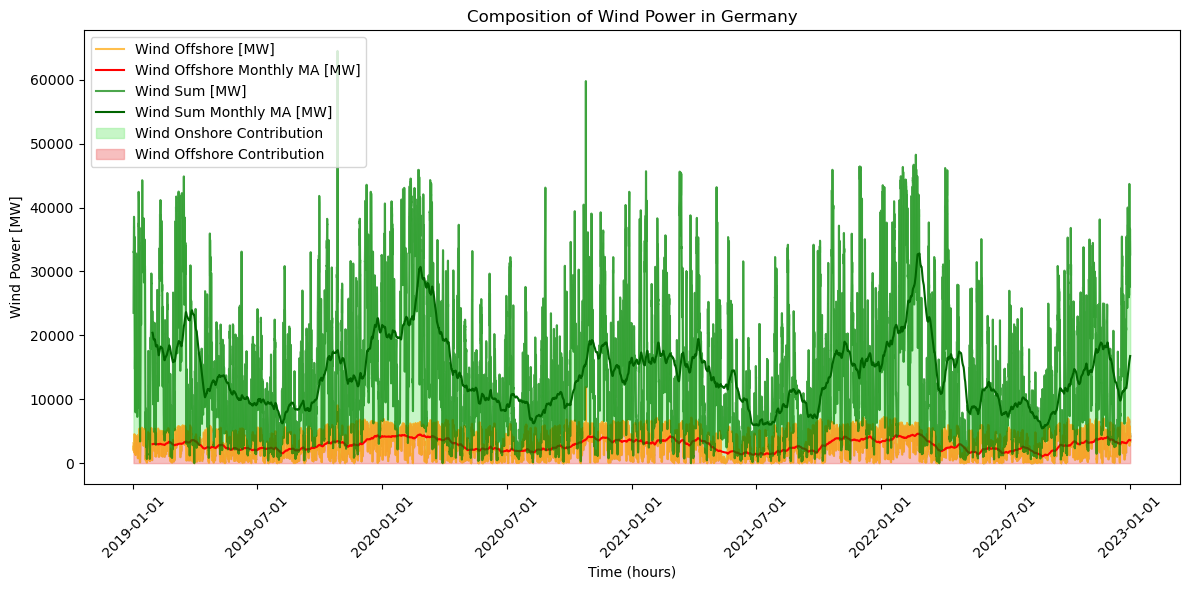

In [41]:
# setup_tueplots()

fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind_offshore, label="Wind Offshore [MW]", color="orange", alpha=0.7)
ax.plot(dates, wind_offshore_mean, label="Wind Offshore Monthly MA [MW]", color="red", alpha=1)
ax.plot(dates, wind, label="Wind Sum [MW]", color="green", alpha=0.7)
ax.plot(dates, wind_mean, label="Wind Sum Monthly MA [MW]", color="darkgreen", alpha=1)
ax.fill_between(dates, wind_offshore, wind, color="lightgreen", alpha=0.5, label="Wind Onshore Contribution")
ax.fill_between(dates, 0, wind_offshore, color="lightcoral", alpha=0.5, label="Wind Offshore Contribution")

ax.set_title("Composition of Wind Power in Germany")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

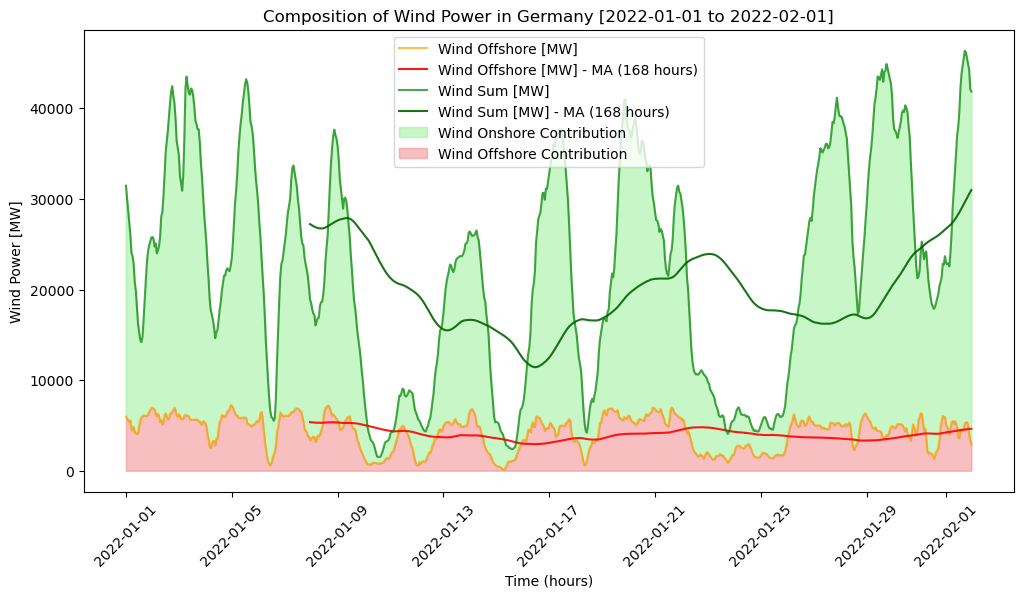

In [42]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2022-02-01"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

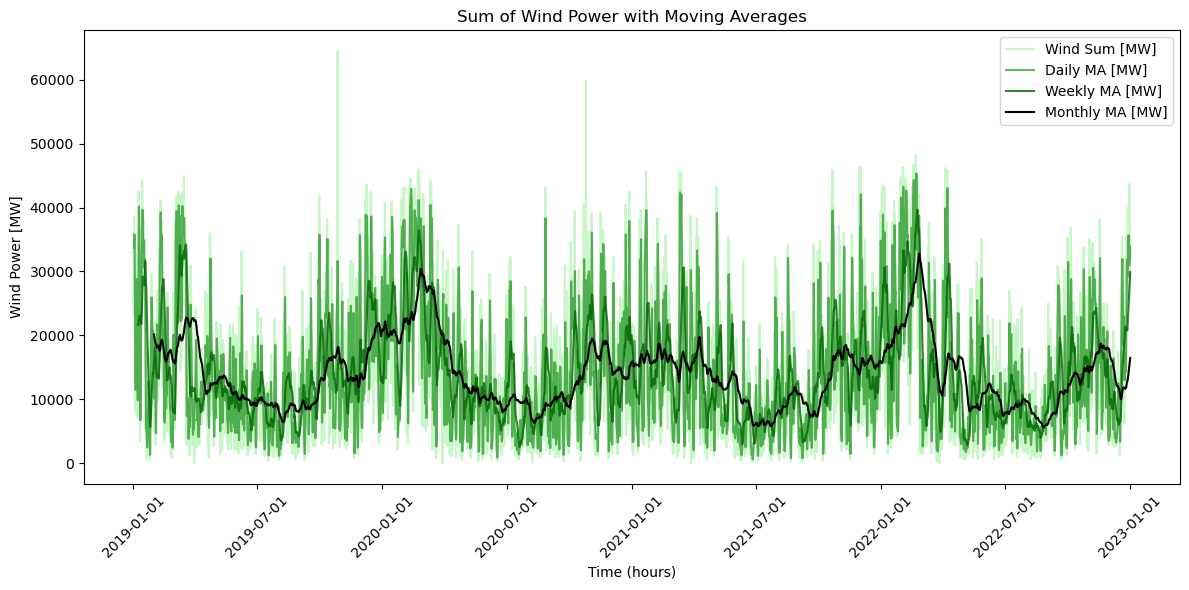

In [43]:
# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="darkgreen", alpha=0.8)
ax.plot(dates, wind_monthly_ma, label="Monthly MA [MW]", color="black", alpha=1)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Weather Data Germany

In [44]:
from src.preprocessing import weather_germany_mean, weather_germany_clustered, weather_north_south_means

In [45]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather_2022_path = Path('..') / "data" / "Weather_Data_Germany_2022.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')
weather_2022 = pd.read_csv(weather_2022_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


In [46]:
def format_weather_time(weather: pd.DataFrame) -> None:
    """Formats weather data time column and sets it as index."""
    weather.drop(columns=["forecast_origin"], inplace=True)
    weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
    weather.set_index("time", inplace=True)
    weather.sort_index(inplace=True)

format_weather_time(weather)
format_weather_time(weather_2022)

weather = pd.concat([weather, weather_2022], axis=0)

In [47]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False

lat_threshold = 51.0
use_north_south_split = True

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
elif use_north_south_split:
    weather = weather_north_south_means(weather, lat_threshold=lat_threshold)
else:
    weather = weather_germany_mean(weather)

In [48]:
from tueplots.constants.color import rgb

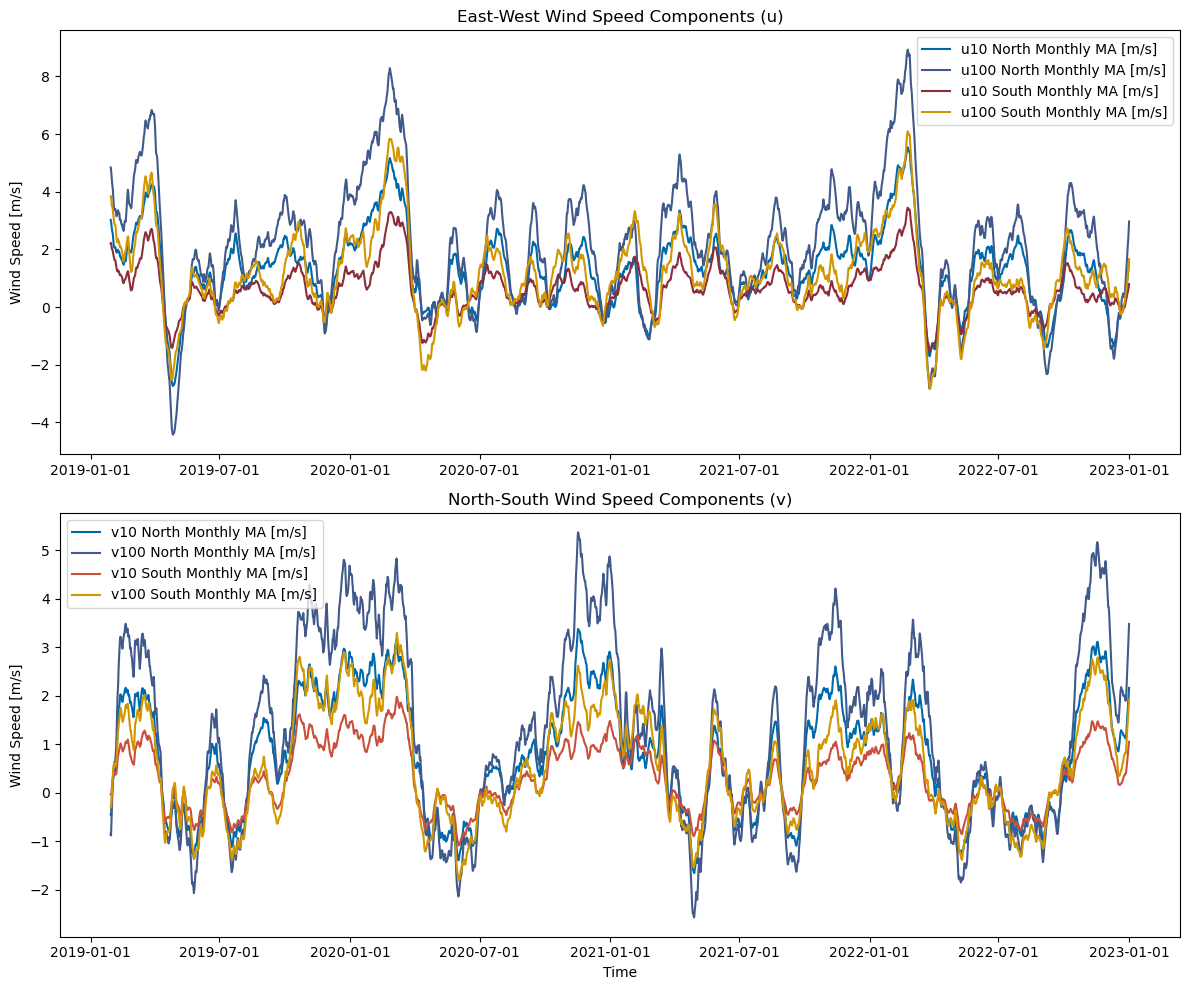

In [49]:
def plot_wind_speed_components(weather: pd.DataFrame) -> None:
    u10_south = weather["u10_south"]
    u100_south = weather["u100_south"]
    v10_south = weather["v10_south"]
    v100_south = weather["v100_south"]
    
    u10_north = weather["u10_north"]
    u100_north = weather["u100_north"]
    v10_north = weather["v10_north"]
    v100_north = weather["v100_north"]

    # Plot the data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    locator1 = ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator1))
    locator2 = ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator2))

    # Plot first subplot - u components
    ax1.plot(weather.index, u10_north.rolling(window=24*7*4).mean(),
             label="u10 North Monthly MA [m/s]", color=rgb.tue_blue, alpha=1)
    ax1.plot(weather.index, u100_north.rolling(window=24*7*4).mean(),
             label="u100 North Monthly MA [m/s]", color=rgb.tue_darkblue, alpha=1)
    ax1.plot(weather.index, u10_south.rolling(window=24*7*4).mean(),
             label="u10 South Monthly MA [m/s]", color=rgb.tue_red, alpha=1)
    ax1.plot(weather.index, u100_south.rolling(window=24*7*4).mean(),
             label="u100 South Monthly MA [m/s]", color=rgb.tue_orange, alpha=1)

    ax1.set_title("East-West Wind Speed Components (u)")
    ax1.set_ylabel("Wind Speed [m/s]")
    ax1.legend()

    # Plot second subplot - v components
    ax2.plot(weather.index, v10_north.rolling(window=24*7*4).mean(),
             label="v10 North Monthly MA [m/s]", color=rgb.tue_blue, alpha=1)
    ax2.plot(weather.index, v100_north.rolling(window=24*7*4).mean(),
             label="v100 North Monthly MA [m/s]", color=rgb.tue_darkblue, alpha=1)
    ax2.plot(weather.index, v10_south.rolling(window=24*7*4).mean(),
             label="v10 South Monthly MA [m/s]", color=rgb.tue_ocre, alpha=1)
    ax2.plot(weather.index, v100_south.rolling(window=24*7*4).mean(),
             label="v100 South Monthly MA [m/s]", color=rgb.tue_orange, alpha=1)

    ax2.set_title("North-South Wind Speed Components (v)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Wind Speed [m/s]")
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_wind_speed_components(weather)


### Machine Learning Setup for Forecasting
- Split data into training and testing sets
- Sliding window approach for time series forecasting
- Feature engineering
   - Create lag features
   - Use weather data as additional features
- Feature selection
   - Select relevant features based on correlation with target variable
   - Mutual Information, Pearson Correlation, Autocorrelation
   - Fit a Lasso regression model and select features based on coefficients (try LassoCV)

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV

from src.preprocessing import create_time_features, create_sliding_window_data

In [51]:
# Join weather data with wind data
target = df[[Column.WIND.value]].copy()
dataframe = target.join(weather, how="inner")

# Create time features
dataframe = create_time_features(dataframe)


In [52]:
# Train and test split
SPLIT_DATE = "2022-01-01"
START_DATE = df.index[0]
END_DATE = df.index[-1]

train_data = dataframe[START_DATE:SPLIT_DATE]
test_data = dataframe[SPLIT_DATE:END_DATE]

In [53]:
target_scaler = StandardScaler()
train_data.loc[:, [Column.WIND.value]] = target_scaler.fit_transform(
    train_data.loc[:, [Column.WIND.value]]
)
test_data.loc[:, [Column.WIND.value]] = target_scaler.transform(
    test_data.loc[:, [Column.WIND.value]]
)

In [54]:
X_df, y_df = create_sliding_window_data(
    data=train_data,
    history=24,
    forecast_horizon=24,
)
X_test_df, y_test_df = create_sliding_window_data(
    data=test_data,
    history=24,
    forecast_horizon=24,
)
print(X_df.columns)

Index(['lag_24', 'lag_23', 'lag_22', 'lag_21', 'lag_20', 'lag_19', 'lag_18',
       'lag_17', 'lag_16', 'lag_15', 'lag_14', 'lag_13', 'lag_12', 'lag_11',
       'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6', 'lag_5', 'lag_4', 'lag_3',
       'lag_2', 'lag_1', 'cdir_south', 'cdir_north', 'z_south', 'z_north',
       'msl_south', 'msl_north', 'blh_south', 'blh_north', 'tcc_south',
       'tcc_north', 'u10_south', 'u10_north', 'v10_south', 'v10_north',
       't2m_south', 't2m_north', 'ssr_south', 'ssr_north', 'tsr_south',
       'tsr_north', 'sund_south', 'sund_north', 'tp_south', 'tp_north',
       'fsr_south', 'fsr_north', 'u100_south', 'u100_north', 'v100_south',
       'v100_north', 'dayofweek_sin', 'dayofweek_cos', 'month_sin',
       'month_cos', 'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')


In [55]:
lag_feature_names = [col for col in X_df.columns if col.startswith("lag_")]
time_feature_names = [col for col in X_df.columns if col.endswith("_sin") or col.endswith("_cos")]
weather_feature_names = list(set(X_df.columns) - set(lag_feature_names) - set(time_feature_names))

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ("weather", StandardScaler(), weather_feature_names),
        ("time", "passthrough", time_feature_names),
        ("lag", "passthrough", lag_feature_names),
    ],
    remainder="drop",
)

In [27]:
horizon_models = []
num_horizons = 24

for h in range(num_horizons):
    print(f"Training LASSO for horizon {h + 1}...")
    
    y_h = y_df.iloc[:, h].values
    
    # lasso_model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
    lasso_model = LassoCV(max_iter=10000, random_state=42)
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", lasso_model),
    ])

    pipeline.fit(X_df, y_h)
    horizon_models.append(pipeline)
    
print("Training complete.")

Training LASSO for horizon 1...
Training LASSO for horizon 2...
Training LASSO for horizon 3...
Training LASSO for horizon 4...
Training LASSO for horizon 5...
Training LASSO for horizon 6...
Training LASSO for horizon 7...
Training LASSO for horizon 8...
Training LASSO for horizon 9...
Training LASSO for horizon 10...
Training LASSO for horizon 11...
Training LASSO for horizon 12...
Training LASSO for horizon 13...
Training LASSO for horizon 14...
Training LASSO for horizon 15...
Training LASSO for horizon 16...
Training LASSO for horizon 17...
Training LASSO for horizon 18...
Training LASSO for horizon 19...
Training LASSO for horizon 20...
Training LASSO for horizon 21...
Training LASSO for horizon 22...
Training LASSO for horizon 23...
Training LASSO for horizon 24...
Training complete.


In [28]:
model_h0 = horizon_models[0]
y_pred_h0 = model_h0.predict(X_test_df)
y_pred_h0 = target_scaler.inverse_transform(y_pred_h0.reshape(-1, 1))

In [29]:
# Store feature importances for each horizon
all_feature_importances = []

print("Feature Selection Analysis:\n")

for h, pipeline_h in enumerate(horizon_models):
    print(f"- Horizon t+{h+1}:")

    preprocessor_step = pipeline_h.named_steps["preprocessor"]
    lasso_model_step = pipeline_h.named_steps["model"]

    transformed_feature_names = preprocessor_step.get_feature_names_out()
    coefficients = lasso_model_step.coef_

    # Create a DataFrame for feature importances for this horizon
    importance_df = pd.DataFrame(
        {"feature": transformed_feature_names, "coefficient": coefficients}
    )

    # filter out features with zero coefficients
    selected_features_df = importance_df[importance_df["coefficient"] != 0].copy()

    # rank features by the absolute magnitude of their coefs
    selected_features_df["abs_coefficient"] = selected_features_df["coefficient"].abs()
    selected_features_df = selected_features_df.sort_values(
        by="abs_coefficient", ascending=False
    )

    all_feature_importances.append(selected_features_df)

    print("Top selected features (ranked by absolute coefficient):")
    print(selected_features_df[["feature", "coefficient"]].head())
    print("\n")


Feature Selection Analysis:

- Horizon t+1:
Top selected features (ranked by absolute coefficient):
          feature  coefficient
46     lag__lag_1     1.219143
44     lag__lag_3    -0.235871
9   weather__v100     0.013578
25    lag__lag_22     0.010063
5    weather__blh     0.009043


- Horizon t+2:
Top selected features (ranked by absolute coefficient):
        feature  coefficient
46   lag__lag_1     1.504696
44   lag__lag_3    -0.308875
45   lag__lag_2    -0.237254
25  lag__lag_22     0.133841
23  lag__lag_24    -0.114737


- Horizon t+3:
Top selected features (ranked by absolute coefficient):
        feature  coefficient
46   lag__lag_1     1.660966
45   lag__lag_2    -0.397241
44   lag__lag_3    -0.328793
23  lag__lag_24    -0.192057
25  lag__lag_22     0.141958


- Horizon t+4:
Top selected features (ranked by absolute coefficient):
        feature  coefficient
46   lag__lag_1     1.730243
45   lag__lag_2    -0.461005
44   lag__lag_3    -0.364616
26  lag__lag_21     0.205076
23

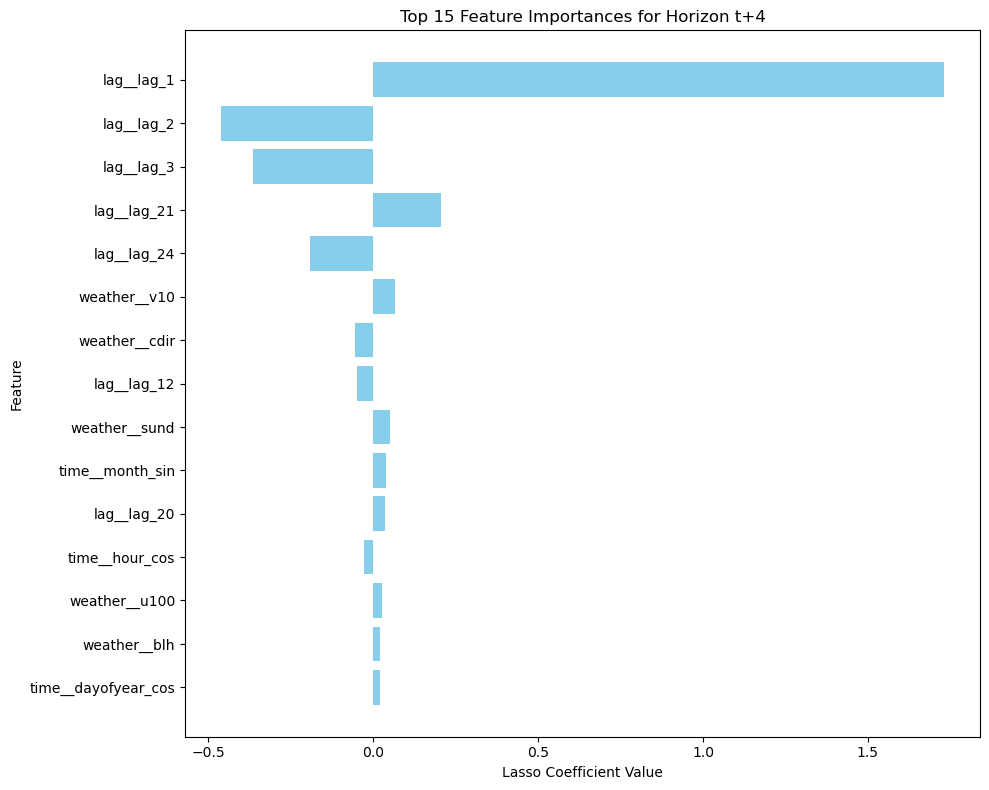

In [34]:
horizon_to_visualize = 3
top_n = 15

features_for_h = all_feature_importances[horizon_to_visualize]

# Select top N features
features_to_plot = features_for_h.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(
    features_to_plot["feature"],
    features_to_plot["coefficient"],
    color="skyblue",
)
plt.xlabel("Lasso Coefficient Value")
plt.ylabel("Feature")
plt.title(
    f"Top {top_n} Feature Importances for Horizon t+{horizon_to_visualize+1}"
)
plt.gca().invert_yaxis()  # Display features from most to least important
plt.tight_layout()
plt.show()


In [33]:
from sklearn.inspection import permutation_importance


all_permutation_importances = []

print("Calculating Permutation Importance on Test Data...\n")

for h, pipeline_h in enumerate(horizon_models):
    print(f"- Horizon t+{h+1}:")

    current_y_test = y_test_df.iloc[:, h]

    perm_importance_result = permutation_importance(
        pipeline_h,
        X_test_df,
        current_y_test,
        scoring="neg_root_mean_squared_error",
        n_repeats=5,
        random_state=42,
    )

    preprocessor_step = pipeline_h.named_steps["preprocessor"]
    transformed_feature_names = preprocessor_step.get_feature_names_out()

    # Sort features by mean importance (descending order)
    sorted_idx = perm_importance_result.importances_mean.argsort()[::-1]

    importance_df = pd.DataFrame(
        {
            "feature": [transformed_feature_names[i] for i in sorted_idx],
            "importance_mean": perm_importance_result.importances_mean[sorted_idx],
            "importance_std": perm_importance_result.importances_std[sorted_idx],
        }
    )

    # Filter for features with positive mean importance 
    # --> score worsened when permuted
    selected_features_df = importance_df[
        importance_df["importance_mean"] > 0
    ].copy()

    all_permutation_importances.append(selected_features_df)

    print("Top features by permutation importance (test set):")
    print(selected_features_df[["feature", "importance_mean"]].head())



Calculating Permutation Importance on Test Data...

- Horizon t+1:
Top features by permutation importance (test set):
               feature  importance_mean
0          lag__lag_24         1.759740
1  time__dayofyear_sin         0.279070
2           lag__lag_9         0.001944
3         weather__u10         0.001685
4          lag__lag_20         0.001283
- Horizon t+2:
Top features by permutation importance (test set):
               feature  importance_mean
0          lag__lag_24         2.120862
1  time__dayofyear_sin         0.328965
2  time__dayofyear_cos         0.229157
3         weather__u10         0.099160
4         weather__ssr         0.073512
- Horizon t+3:
Top features by permutation importance (test set):
               feature  importance_mean
0          lag__lag_24         2.292260
1  time__dayofyear_cos         0.406065
2  time__dayofyear_sin         0.310038
3         weather__ssr         0.136144
4         weather__u10         0.086120
- Horizon t+4:
Top features by

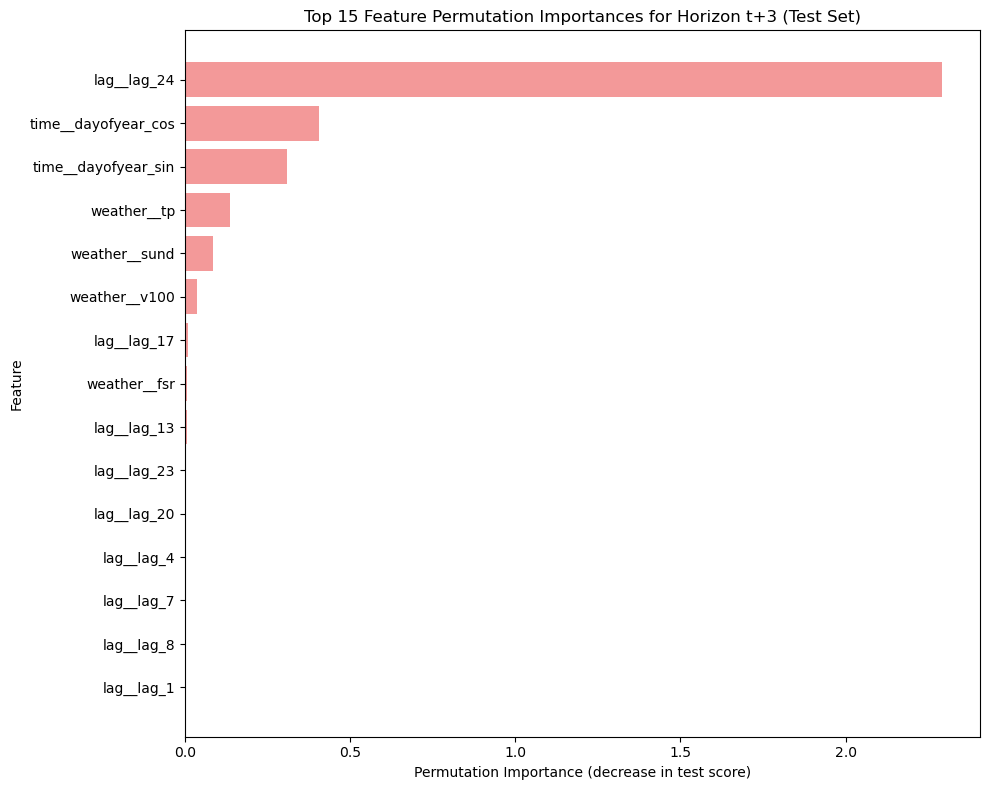

In [31]:
horizon_to_visualize_perm = 2
top_n_perm = 15

features_for_h_perm = all_permutation_importances[horizon_to_visualize_perm]

features_to_plot_perm = features_for_h_perm.head(top_n_perm)

plt.figure(figsize=(10, 8))
plt.barh(
    features_to_plot_perm["feature"],
    features_to_plot_perm["importance_mean"],
    align="center",
    alpha=0.8,
    ecolor="black",
    capsize=5,
    color="lightcoral",
)
plt.xlabel("Permutation Importance (decrease in test score)")
plt.ylabel("Feature")
plt.title(
    f"Top {top_n_perm} Feature Permutation Importances for Horizon t+{horizon_to_visualize_perm+1} (Test Set)"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
    

In [57]:
from src.feature_selection import (
    calculate_correlation_scores,
    calculate_mutual_information_scores,
    plot_feature_metrics_summary,
    create_correlation_matrix,
    create_mutual_information_matrix
)

Calculating Pearson correlation for 30 features with the target...
Calculating Mutual Information scores for 30 features...


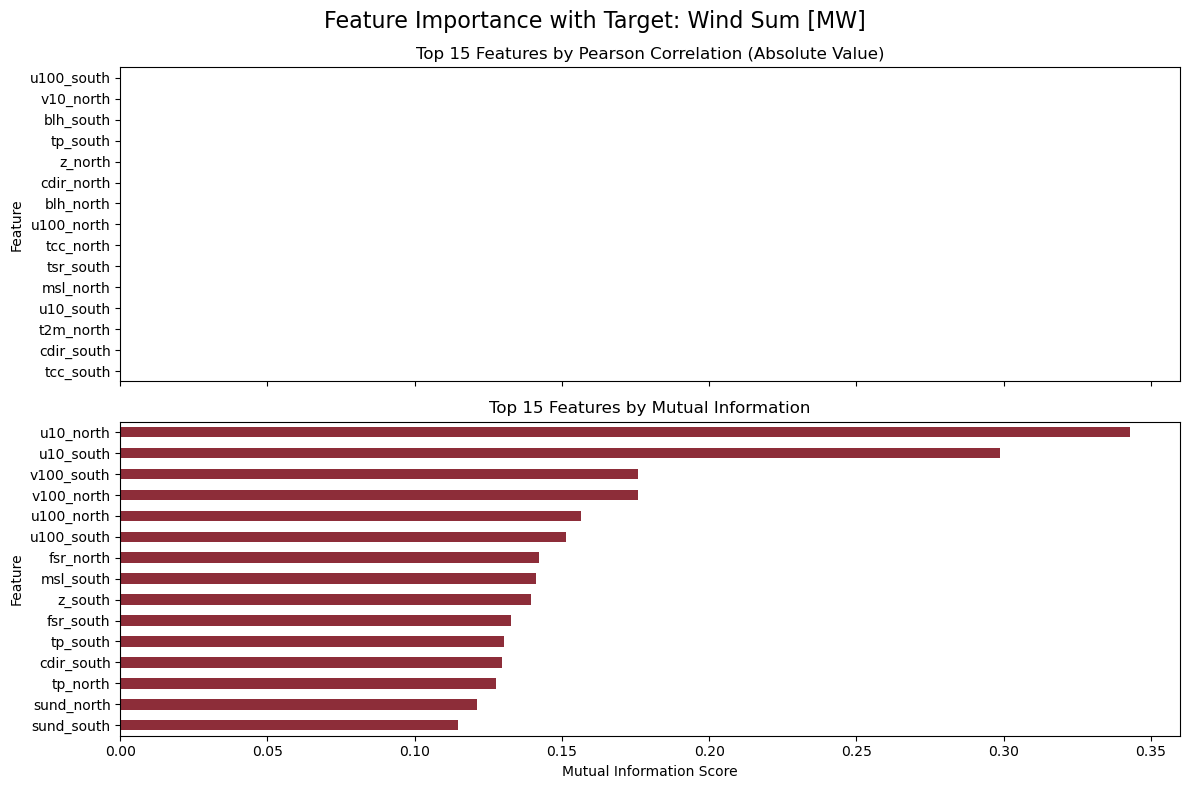

In [61]:
horizon = 20
# data = X_df.copy()  # all features
data = X_df[weather_feature_names].copy()  # only weather features

correlation_scores = calculate_correlation_scores(data, y_df.iloc[:, horizon])
mutual_information_scores = calculate_mutual_information_scores(data, y_df.iloc[:, horizon])
plot_feature_metrics_summary(
    correlation_scores,
    mutual_information_scores,
    target_variable_name=Column.WIND.value,
    top_n=15,
)

Calculating Pearson correlation matrix for 14 features...


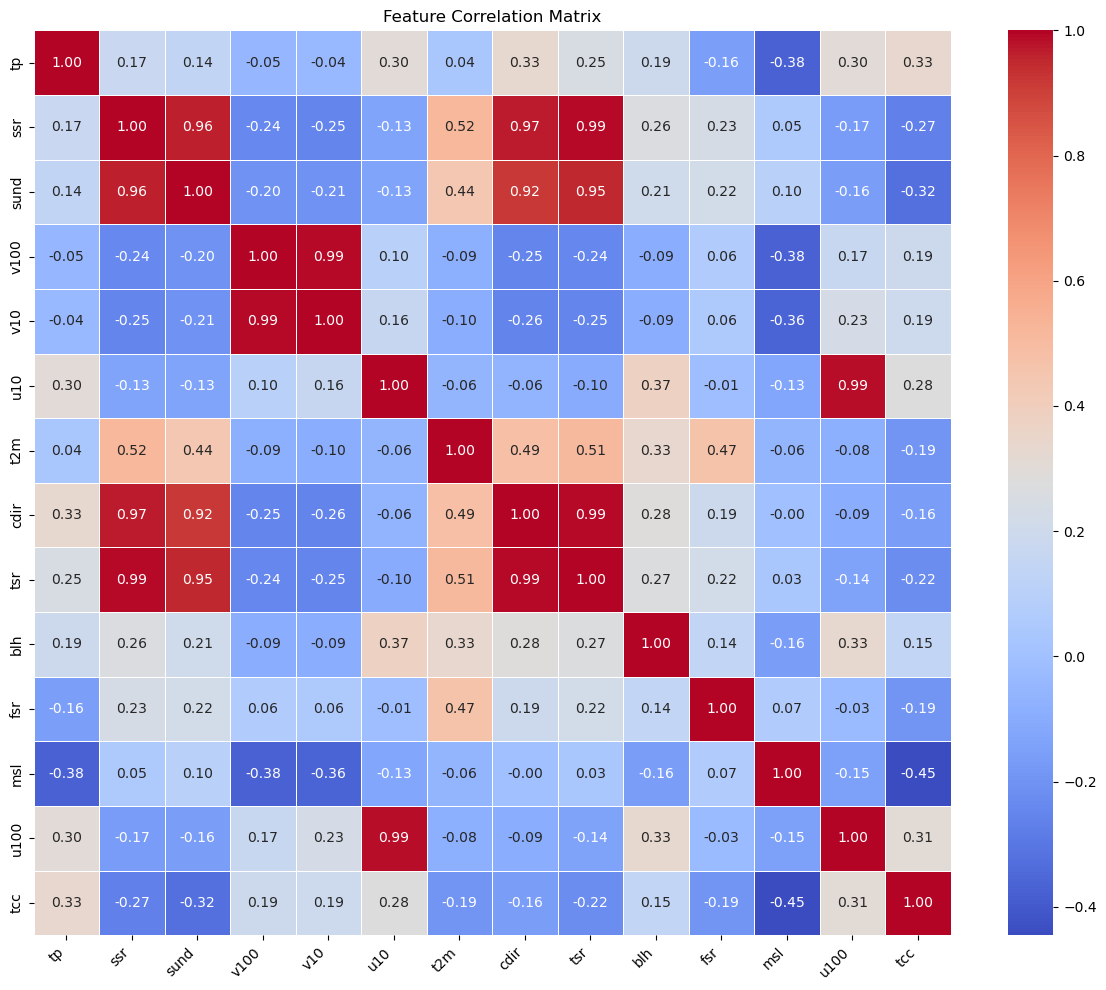

,tp,ssr,sund,v100,v10,u10,t2m,cdir,tsr,blh,fsr,msl,u100,tcc
tp,1.000000,0.172989,0.140766,-0.046708,-0.035734,0.301003,0.037008,0.329598,0.247595,0.188512,-0.156601,-0.377099,0.302579,0.333884
ssr,0.172989,1.000000,0.962902,-0.241672,-0.249043,-0.133240,0.518697,0.970583,0.993954,0.264098,0.232731,0.054237,-0.166818,-0.268584
sund,0.140766,0.962902,1.000000,-0.200144,-0.206161,-0.131053,0.444731,0.919816,0.953958,0.207747,0.215737,0.099225,-0.161846,-0.322664
v100,-0.046708,-0.241672,-0.200144,1.000000,0.990190,0.097354,-0.085733,-0.252953,-0.244563,-0.092697,0.063719,-0.377641,0.167320,0.190794
v10,-0.035734,-0.249043,-0.206161,0.990190,1.000000,0.161897,-0.095246,-0.256483,-0.250160,-0.094302,0.055990,-0.361914,0.231011,0.194981
u10,0.301003,-0.133240,-0.131053,0.097354,0.161897,1.000000,-0.056675,-0.062060,-0.103146,0.373395,-0.013457,-0.126652,0.987952,0.280959
t2m,0.037008,0.518697,0.444731,-0.085733,-0.095246,-0.056675,1.000000,0.485221,0.513902,0.334160,0.465244,-0.057347,-0.084970,-0.194309
cdir,0.329598,0.970583,0.919816,-0.252953,-0.256483,-0.062060,0.485221,1.000000,0.989798,0.282984,0.191900,-0.000866,-0.094780,-0.159299
tsr,0.247595,0.993954,0.953958,-0.244563,-0.250160,-0.103146,0.513902,0.989798,1.000000,0.267496,0.218570,0.029281,-0.136239,-0.221389
blh,0.188512,0.264098,0.207747,-0.092697,-0.094302,0.373395,0.334160,0.282984,0.267496,1.000000,0.144278,-0.162250,0.330813,0.146667


In [34]:
# Redundancy analysis using correlation matrix
create_correlation_matrix(data.drop(columns=["z"]))

Calculating Mutual Information matrix for 14 features...


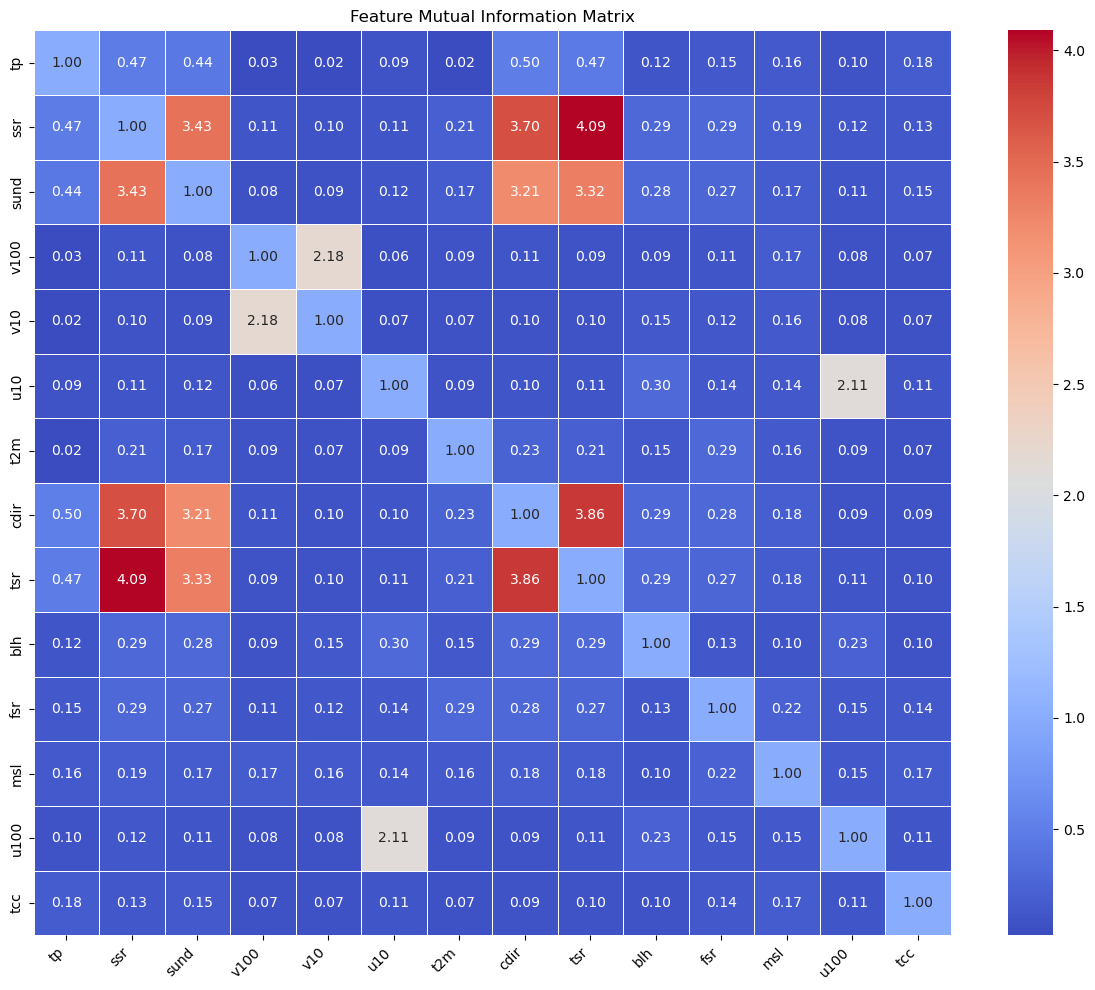

,tp,ssr,sund,v100,v10,u10,t2m,cdir,tsr,blh,fsr,msl,u100,tcc
tp,1.0,0.47005,0.438668,0.027749,0.023268,0.092007,0.022673,0.498939,0.467173,0.115963,0.148014,0.163404,0.099331,0.180018
ssr,0.470189,1.0,3.427541,0.107623,0.10104,0.110466,0.20523,3.697986,4.087038,0.28924,0.287885,0.18673,0.118553,0.125269
sund,0.438559,3.425953,1.0,0.082487,0.085088,0.115992,0.166186,3.210092,3.322079,0.282047,0.270511,0.171712,0.107636,0.152337
v100,0.027718,0.107622,0.082699,1.0,2.184563,0.062075,0.086398,0.10655,0.088564,0.0895,0.107166,0.169139,0.07815,0.072293
v10,0.02343,0.101283,0.085372,2.184563,1.0,0.065349,0.073527,0.101591,0.100577,0.14736,0.118753,0.163814,0.082788,0.071274
u10,0.091947,0.110628,0.115606,0.062075,0.065349,1.0,0.092907,0.102802,0.112868,0.299196,0.141811,0.141027,2.108431,0.109105
t2m,0.02261,0.205638,0.166388,0.086398,0.073527,0.092907,1.0,0.231765,0.208745,0.146645,0.292636,0.16376,0.094301,0.071357
cdir,0.49995,3.698961,3.208173,0.106672,0.101909,0.103035,0.231715,1.0,3.860847,0.292414,0.277315,0.182733,0.090213,0.091087
tsr,0.467698,4.090622,3.325834,0.088521,0.100622,0.113111,0.208699,3.864929,1.0,0.294348,0.274193,0.177395,0.105423,0.099661
blh,0.116,0.289207,0.281962,0.0895,0.14736,0.299196,0.146645,0.292357,0.294371,1.0,0.132365,0.102749,0.228389,0.100567


In [35]:
# Redundancy analysis using mutual information matrix
create_mutual_information_matrix(data.drop(columns=["z"]))